# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14678892239041980656
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 531325610138471868
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 20:28:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    31W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'InceptionV3'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 7
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4", "S5", "S6"
T_all_labels = "T0", "T1", "T2", "T3", "T4", "T5", "T6"

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_InceptionV3_None S_InceptionV3_imagenet T_InceptionV3_None T_InceptionV3_imagenet


['S_InceptionV3_imagenet',
 'S_InceptionV3_None',
 'T_InceptionV3_imagenet',
 'T_InceptionV3_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)

(2358, 128, 128, 3) (2358, 1)
(786, 128, 128, 3) (786, 1)
(786, 128, 128, 3) (786, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2598, 128, 128, 3) (2598, 7)
(866, 128, 128, 3) (866, 7)
(866, 128, 128, 3) (866, 7)

(2358, 128, 128, 3) (2358, 7)
(786, 128, 128, 3) (786, 7)
(786, 128, 128, 3) (786, 7)


## 2-2. Image Check

xTrain_S image Numbers :  2598
xTrain_S image Numbers // 10 :  259
11


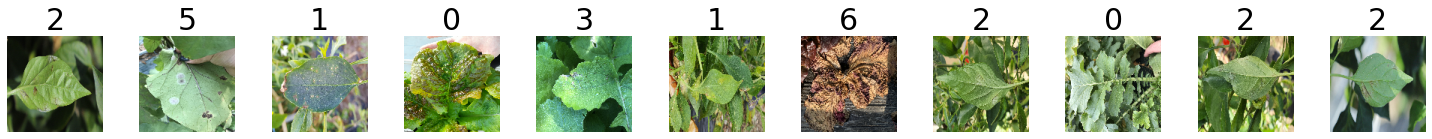

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2358
xTrain_S image Numbers // 10 :  235
11


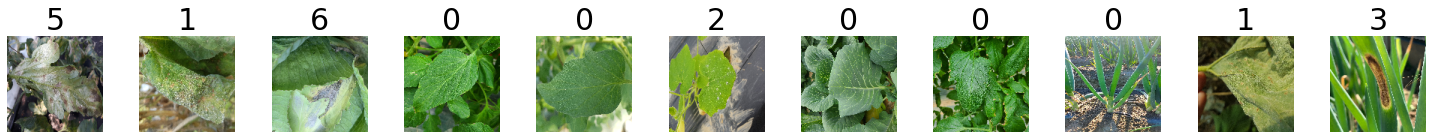

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 22s 179ms/step - loss: 1.4547 - accuracy: 0.4727 - val_loss: 1.9468 - val_accuracy: 0.1848
Epoch 2/100
41/41 [==============================] - 5s 117ms/step - loss: 0.8763 - accuracy: 0.6925 - val_loss: 2.2388 - val_accuracy: 0.1155
Epoch 3/100
41/41 [==============================] - 5s 117ms/step - loss: 0.7652 - accuracy: 0.7483 - val_loss: 2.7862 - val_accuracy: 0.1848
Epoch 4/100
41/41 [==============================] - 5s 117ms/step - loss: 0.7093 - accuracy: 0.7640 - val_loss: 4.8503 - val_accuracy: 0.1085
Epoch 5/100
41/41 [==============================] - 5s 120ms/step - loss: 0.5762 - accuracy: 0.8048 - val_loss: 6.0613 - val_accuracy: 0.1975
Epoch 6/100
41/41 [==============================] - 5s 117ms/step - loss: 0.5209 - accuracy: 0.8195 - val_loss: 8.2208 - val_accuracy: 0.1848
Epoch 7/100
41/41 [==============================] - 5s 120ms/step - loss: 0.4455 - accuracy: 0.8437 - val_loss: 3.6025 - val_accuracy: 0.219

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.454738,0.472671,1.946766,0.184758
1,0.876343,0.692456,2.238846,0.115473
2,0.765159,0.748268,2.786233,0.184758
3,0.709251,0.764049,4.850286,0.108545
4,0.576222,0.804850,6.061348,0.197460
...,...,...,...,...
68,0.096382,0.974596,1.988024,0.572748
69,0.079652,0.975751,1.121806,0.728637
70,0.084758,0.975366,0.796030,0.831409
71,0.070246,0.976905,1.342018,0.741340


Minimum validation loss: 0.44000300765037537
Maximum validation accuracy: 0.8822171092033386


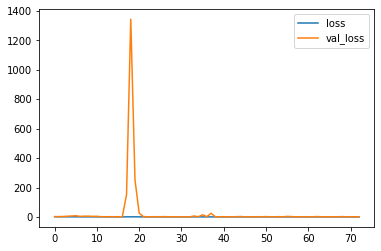

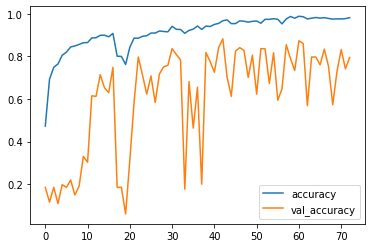

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
28/28 [==============================] - 1s 33ms/step - loss: 0.5139 - accuracy: 0.8661
test loss, test acc: [0.5138561725616455, 0.8660507798194885]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

28/28 [==============================] - 2s 23ms/step


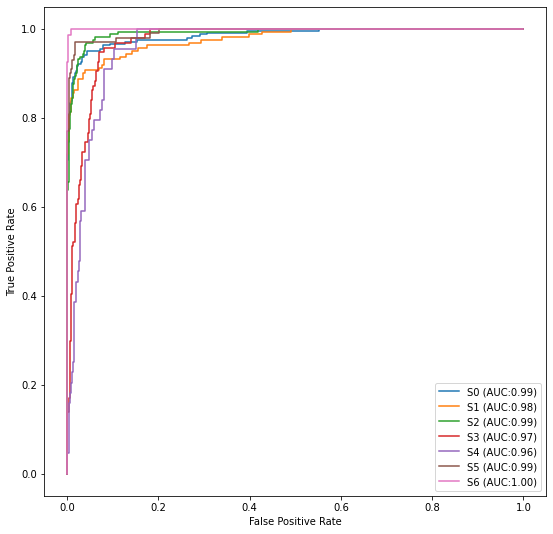

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 12s 153ms/step - loss: 0.8617 - accuracy: 0.6998 - val_loss: 9.3587 - val_accuracy: 0.2806
Epoch 2/100
41/41 [==============================] - 5s 120ms/step - loss: 0.4053 - accuracy: 0.8641 - val_loss: 8.5950 - val_accuracy: 0.2898
Epoch 3/100
41/41 [==============================] - 5s 119ms/step - loss: 0.2838 - accuracy: 0.9026 - val_loss: 9.6275 - val_accuracy: 0.2921
Epoch 4/100
41/41 [==============================] - 5s 120ms/step - loss: 0.1949 - accuracy: 0.9361 - val_loss: 3.2839 - val_accuracy: 0.5069
Epoch 5/100
41/41 [==============================] - 5s 119ms/step - loss: 0.1798 - accuracy: 0.9477 - val_loss: 1.0774 - val_accuracy: 0.7483
Epoch 6/100
41/41 [==============================] - 5s 117ms/step - loss: 0.1139 - accuracy: 0.9619 - val_loss: 1.8889 - val_accuracy: 0.7379
Epoch 7/100
41/41 [==============================] - 5s 116ms/step - loss: 0.1393 - accuracy: 0.9565 - val_loss: 1.7074 - val_accuracy: 0.653

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.861674,0.699769,9.358743,0.280600
1,0.405305,0.864126,8.595035,0.289838
2,0.283753,0.902617,9.627546,0.292148
3,0.194929,0.936105,3.283947,0.506928
4,0.179777,0.947652,1.077398,0.748268
5,0.113922,0.961894,1.888868,0.737875
6,0.139279,0.956505,1.707351,0.653580
7,0.148241,0.954580,0.880542,0.793303
8,0.108838,0.967667,0.766467,0.811778
9,0.125875,0.966513,0.632185,0.837182


Minimum validation loss: 0.23787300288677216
Maximum validation accuracy: 0.949191689491272


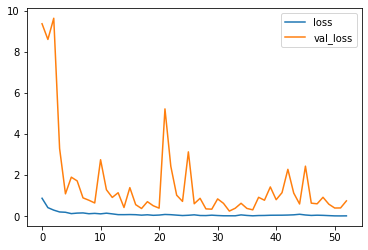

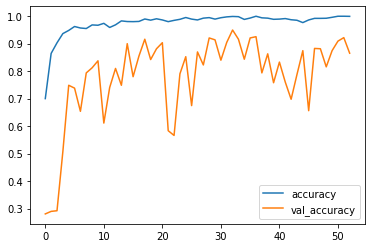

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
28/28 [==============================] - 1s 27ms/step - loss: 0.2994 - accuracy: 0.9319
test loss, test acc: [0.29940730333328247, 0.931870698928833]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

28/28 [==============================] - 2s 24ms/step


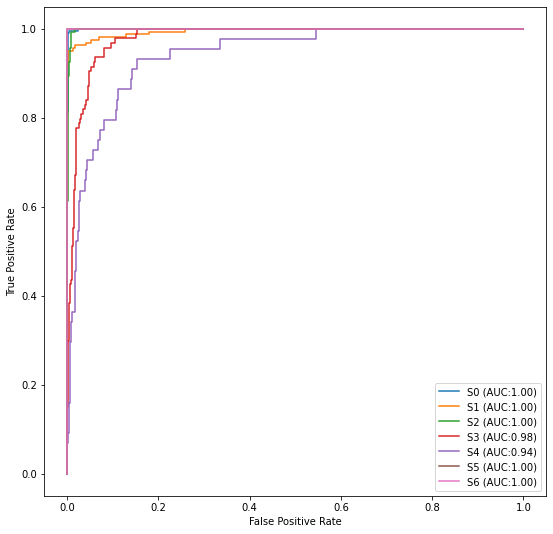

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 13s 185ms/step - loss: 1.4544 - accuracy: 0.4822 - val_loss: 1.9174 - val_accuracy: 0.3053
Epoch 2/100
37/37 [==============================] - 4s 117ms/step - loss: 0.8705 - accuracy: 0.7087 - val_loss: 2.0128 - val_accuracy: 0.1310
Epoch 3/100
37/37 [==============================] - 4s 117ms/step - loss: 0.7552 - accuracy: 0.7477 - val_loss: 7.6196 - val_accuracy: 0.0560
Epoch 4/100
37/37 [==============================] - 4s 119ms/step - loss: 0.5052 - accuracy: 0.8342 - val_loss: 12.2922 - val_accuracy: 0.0560
Epoch 5/100
37/37 [==============================] - 4s 118ms/step - loss: 0.4336 - accuracy: 0.8630 - val_loss: 4.7633 - val_accuracy: 0.0865
Epoch 6/100
37/37 [==============================] - 4s 121ms/step - loss: 0.4171 - accuracy: 0.8694 - val_loss: 5.7975 - val_accuracy: 0.3257
Epoch 7/100
37/37 [==============================] - 4s 118ms/step - loss: 0.3569 - accuracy: 0.8927 - val_loss: 6.6130 - val_accuracy: 0.13

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.454353,0.482188,1.917353,0.305344
1,0.870481,0.708651,2.012839,0.131043
2,0.755242,0.747667,7.619561,0.055980
3,0.505225,0.834181,12.292184,0.055980
4,0.433646,0.863020,4.763274,0.086514
...,...,...,...,...
77,0.025134,0.991518,0.678070,0.862595
78,0.044076,0.986853,0.971405,0.802799
79,0.029831,0.991094,0.291489,0.924936
80,0.051214,0.985581,0.942723,0.832061


Minimum validation loss: 0.2290193736553192
Maximum validation accuracy: 0.9376590251922607


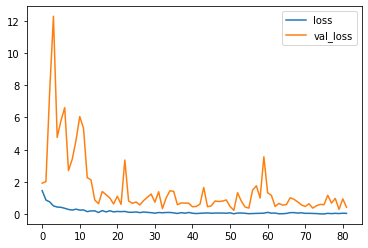

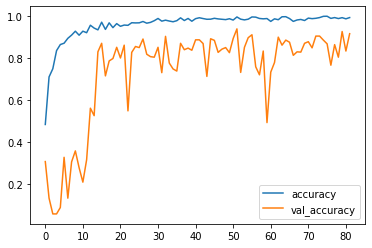

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
25/25 [==============================] - 1s 26ms/step - loss: 0.3587 - accuracy: 0.9249
test loss, test acc: [0.3586992621421814, 0.9249364137649536]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

25/25 [==============================] - 2s 23ms/step


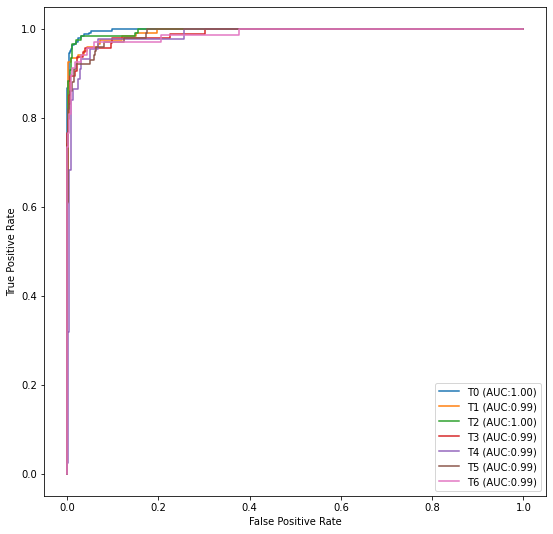

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 12s 157ms/step - loss: 0.9134 - accuracy: 0.6879 - val_loss: 47.8468 - val_accuracy: 0.1527
Epoch 2/100
37/37 [==============================] - 4s 121ms/step - loss: 0.3132 - accuracy: 0.9092 - val_loss: 9.0261 - val_accuracy: 0.2824
Epoch 3/100
37/37 [==============================] - 4s 121ms/step - loss: 0.1607 - accuracy: 0.9550 - val_loss: 1.9954 - val_accuracy: 0.6921
Epoch 4/100
37/37 [==============================] - 4s 118ms/step - loss: 0.1702 - accuracy: 0.9555 - val_loss: 3.4625 - val_accuracy: 0.5852
Epoch 5/100
37/37 [==============================] - 4s 121ms/step - loss: 0.1551 - accuracy: 0.9559 - val_loss: 0.7609 - val_accuracy: 0.7952
Epoch 6/100
37/37 [==============================] - 4s 117ms/step - loss: 0.1277 - accuracy: 0.9597 - val_loss: 2.0763 - val_accuracy: 0.6056
Epoch 7/100
37/37 [==============================] - 4s 118ms/step - loss: 0.1013 - accuracy: 0.9720 - val_loss: 3.2148 - val_accuracy: 0.60

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.913355,0.687871,47.846832,0.152672
1,0.313152,0.909245,9.026115,0.282443
2,0.160729,0.955047,1.995376,0.692112
3,0.170245,0.955471,3.462548,0.585242
4,0.155136,0.955895,0.760903,0.795165
5,0.127701,0.959712,2.076323,0.605598
6,0.101322,0.972010,3.214759,0.609415
7,0.050730,0.985157,0.540339,0.879135
8,0.094214,0.976675,2.895492,0.569975
9,0.120236,0.965225,1.341598,0.796438


Minimum validation loss: 0.1381440907716751
Maximum validation accuracy: 0.9643765687942505


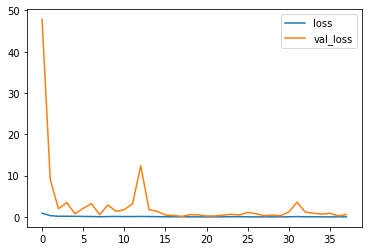

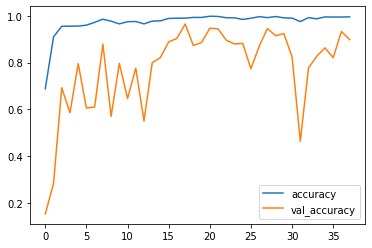

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
25/25 [==============================] - 1s 27ms/step - loss: 0.1840 - accuracy: 0.9453
test loss, test acc: [0.1840342879295349, 0.945292592048645]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

25/25 [==============================] - 2s 23ms/step


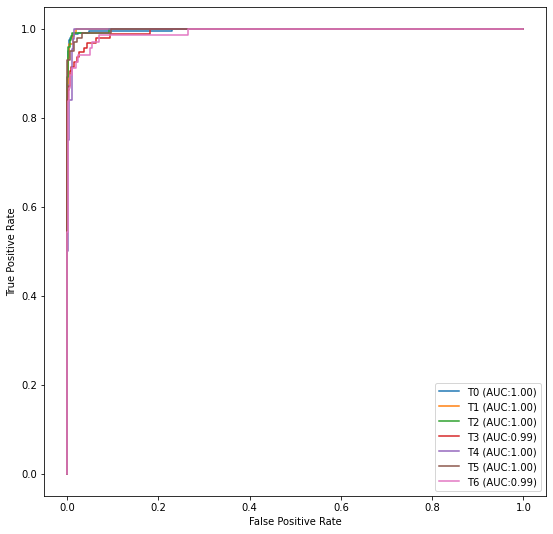

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_InceptionV3_None
test loss, test acc: [0.5138561725616455, 0.8660507798194885]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_InceptionV3_imagenet
test loss, test acc: [0.29940730333328247, 0.931870698928833]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_InceptionV3_None
test loss, test acc: [0.3586992621421814, 0.9249364137649536]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_InceptionV3_imagenet
test loss, test acc: [0.1840342879295349, 0.945292592048645]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_InceptionV3_None →→→ Target Test
25/25 [==============================] - 1s 27ms/step - loss: 5.3562 - accuracy: 0.2341
test loss, test acc: [5.356244087219238, 0.2340966910123825]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_InceptionV3_imagenet →→→ Target Test
25/25 [==============================] - 1s 27ms/step - loss: 5.0601 - accuracy: 0.1934
test loss, test acc: [5.060129642486572, 0.19338423013687134]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_InceptionV3_None →→→ Source Test
28/28 [==============================] - 1s 27ms/step - loss: 5.1183 - accuracy: 0.1905
test loss, test acc: [5.118306636810303, 0.1905311793088913]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_InceptionV3_imagenet →→→ Source Test
28/28 [==============================] - 1s 26ms/step - loss: 4.5332 - accuracy: 0.1628
test loss, test acc: [4.533163547515869, 0.1628175526857376]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )